<a href="https://fangli-ying.github.io/" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. GAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://fangli-ying.github.io/)

在第 2 章中，我们按文件夹可视化了 Victorain400 数据集中的图像。在第 3 章中，我们将构建一个使用 GAN 将黑白图像转换为彩色图像的模型。



在第 3.1 节中，我们将加载用于建模的数据，在第 3.2 节中，我们将定义一个数据集类，甚至一个数据加载器。在 3.3 节中，我们将通过定义 Generator 类和 Discriminator 类来构建模型。在3.4节中，我们将设置超参数并训练构建的模型，然后在3.5节中对测试数据进行预测和性能评估。

## 3.1 数据集下载

我们将使用 2.1 节中的代码下载要在模型中使用的数据集。流程是使用Fake Research Institute GitHub上的Tutorial-Book-Utils，clone使用PL_data_loader.py文件下载Victorian400数据集，并解压。

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data GAN-Colorization
!unzip -q Victorian400-GAN-colorization-data.zip

这次，我们将导入第 3 章中将使用的包。os和glob是可以指定文件路径的包，datetime是可以计算日期和时间的包。和numpy是用于数值运算的线性代数包， 和matplotlib是PIL用于Image可视化图像文件的包。 Othertorch和torchvision包是基于 Torch 的包，用于定义数据集和构建模型。

In [ ]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## 3.2 数据集类定义¶

让我们定义一个数据集类来学习 PyTorch 模型中的数据。它接收文件夹路径以及黑白和彩色图像的图像转换作为参数Image.open，并使用函数来加载图像。.convert("L")使用 单个通道接收黑白图像，.convert("RGB")使用 3 个通道接收彩色图像。图像转换后，黑白图像和彩色图像分别以字典的形式返回到“A”和“B”。

In [ ]:
class VictorianDataset(Dataset):
    def __init__(self, root, color_transforms_=None, gray_transforms_=None):
        """
        初始化数据集。

        参数:
        root (str): 数据集的根目录。
        color_transforms_ (callable, optional): 彩色图像的转换函数。默认为 None。
        gray_transforms_ (callable, optional): 灰度图像的转换函数。默认为 None。
        """
        # 将传入的颜色变换列表组合成一个变换函数
        self.color_transforms = transforms.Compose(color_transforms_)
        # 将传入的灰度变换列表组合成一个变换函数
        self.gray_transforms = transforms.Compose(gray_transforms_)
        # 对根目录下的灰度图像文件进行排序
        self.gray_files = sorted(glob.glob(os.path.join(root, 'gray') + "/*.*"))
        # 对根目录下的彩色图像文件进行排序
        self.color_files = sorted(glob.glob(os.path.join(root, 'resized') + "/*.*"))
    
    def __getitem__(self, index):
        """
        获取数据集中的一个样本。

        参数:
        index (int): 样本的索引。

        返回:
        dict: 包含灰度图像和彩色图像的字典。
        """
        # 打开灰度图像文件并转换为灰度模式
        gray_img = Image.open(self.gray_files[index % len(self.gray_files)]).convert("L")
        # 打开彩色图像文件并转换为RGB模式
        color_img = Image.open(self.color_files[index % len(self.color_files)]).convert("RGB")
    
        # 对灰度图像应用变换
        gray_img = self.gray_transforms(gray_img)
        # 对彩色图像应用变换
        color_img = self.color_transforms(color_img)

        # 返回包含灰度图像和彩色图像的字典
        return {"A": gray_img, "B": color_img}

    def __len__(self):
        """
        返回数据集中的样本数量。

        返回:
        int: 数据集的长度。
        """
        # 返回灰度图像文件的数量
        return len(self.gray_files)



指定每个数据集的图像路径、大小和批量大小。您可以根据您的环境（最大内存使用量）设置图像大小和批量大小。不过，稍后发布的模型结构固定为256，因此如果想要不同的图像尺寸，模型结构也需要进行一些修改。

In [ ]:
root = ''
test_root = root + 'test/'

img_height = 256
img_width = 256

batch_size = 12
test_batch_size = 6

gpu = 0

指定要作为参数输入到数据集类的图像变换。在本教程中，我们将其更改为张量类型，将其插入到 PyTorch 模型中，并使用 2.4 节中获得的平均值和标准差normalize。除此之外，您还可以根据模型结构Resize或根据域执行各种图像变换，例如RandomCrop（随机裁剪）或（随机水平翻转）。RandomVerticalFlip

In [ ]:
color_mean = [0.58090717, 0.52688643, 0.45678478]
color_std = [0.25644188, 0.25482641, 0.24456465]
gray_mean = [0.5350533]
gray_std = [0.25051587]

color_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=color_mean, std=color_std),
]

gray_transforms_ = [
    transforms.Resize(size=(img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=gray_mean, std=gray_std),
]

将上面定义的数据集类和图像变换DataLoader插入到函数中。

In [ ]:
train_loader = DataLoader(
    VictorianDataset(root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=batch_size,
    shuffle=True
)

让我们可视化我们的数据加载器，看看它是否配置正确。由于标准化图像存储在数据加载器中，因此必须恢复标准化并可视化。因此，reNormalize我们创建一个函数来再次乘以标准差并加上平均值。此时.transpose()，改变轴的顺序，将小于min的值改为min，如果大于max则将其改为max。另外，由于“A”对应的黑白图像是单通道的，因此必须将其转换为 2D并设置才能正确显示图像。.clip(min, max).reshape()cmap=gray

In [ ]:
def reNormalize(img, mean, std):
    img = img.numpy().transpose(1, 2, 0)
    img = img * std + mean
    img = img.clip(0, 1)
    return img  

torch.Size([12, 1, 256, 256]) torch.Size([12, 3, 256, 256])


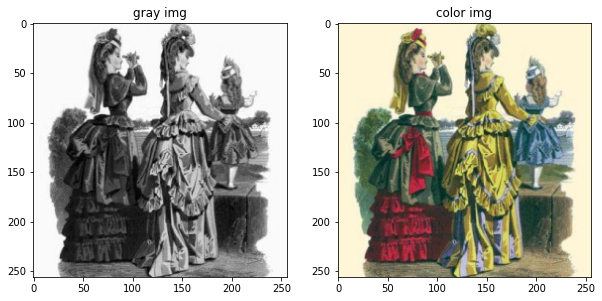

In [ ]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in train_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray') 
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

数据加载器配置正确，黑白和彩色图像输出良好。同样，让我们​​定义并可视化测试数据加载器。

In [ ]:
test_loader = DataLoader(
    VictorianDataset(test_root, color_transforms_=color_transforms_, gray_transforms_=gray_transforms_),
    batch_size=test_batch_size,
    shuffle=False
)

torch.Size([6, 1, 256, 256]) torch.Size([6, 3, 256, 256])


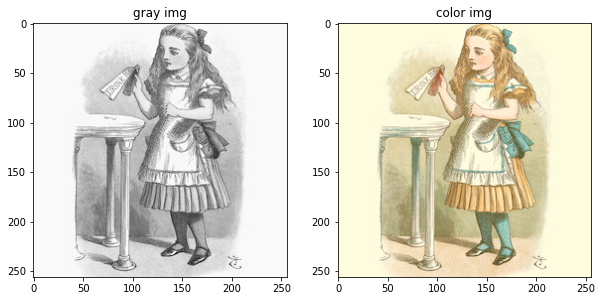

In [ ]:
fig = plt.figure(figsize=(10,5))
rows = 1 
cols = 2

for X in test_loader:
    
    print(X['A'].shape, X['B'].shape)
    ax1 = fig.add_subplot(rows, cols, 1)
    ax1.imshow(reNormalize(X["A"][0], gray_mean, gray_std).reshape(img_height, img_width), cmap='gray')
    ax1.set_title('gray img')

    ax2 = fig.add_subplot(rows, cols, 2)
    ax2.imshow(reNormalize(X["B"][0], color_mean, color_std))
    ax2.set_title('color img')    

    plt.show()
    break

您可以看到测试数据加载器也配置良好。



## 3.3 模型构建¶

这次，我们将构建一个模型来学习数据集。在3.3节中，我们将使用GAN模型将黑白图像转换为彩色图像。 GAN 模型由生成器和判别器组成。每个Conv2d由ConvTranspose2d、MaxPool2d、标准化和激活函数组成。

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        """noise image + gray image"""
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64 * 2 , 3, 1, 1),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.1)
        )
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.conv1by1 = nn.Sequential(
            nn.Conv2d(64,64,1,1,0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1)
        )
        
        
        self.conv = nn.Sequential(
            nn.Conv2d(64, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, input):
        output1 = self.conv1(input)
        pool1 = self.maxpool(output1)
        output2 = self.conv2(pool1)
        output3 = self.upsample(output2) + output1
        output4 = self.conv1by1(output3)
        out = self.conv(output4)        
        return out

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(64,128,kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 128, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            
            nn.Conv2d(512, 1024, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace = True),
            
            )
        
        
        self.fc = nn.Sequential(
            nn.Linear(1024 * 8 * 8 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, batch_size),
            nn.Sigmoid()
        )
        
    def forward(self, input, b_size):
        output = self.main(input)
        output = self.fc(output.view(b_size,-1))
        return output

学习时，必须初始化每个批次的权重。因此weights_init，创建一个函数并将其附加到生成器和判别器模型。

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:        
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

.cuda(gpu)然后，将模型传递到GPU 上训练生成器和判别器。此时，gpu上面指定的设备就被输入了。您可以通过输出内容检查模型结构。

In [ ]:
Gener = Generator().cuda(gpu) if torch.cuda.is_available() else Generator()
Gener.apply(weights_init)

Generator(
  (conv1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv1by1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

In [ ]:
Discri = Discriminator().cuda(gpu) if torch.cuda.is_available() else Discriminator()
Discri.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

## 3.4 模型训练¶

现在让我们训练构建的模型。让我们将学习计数设置为 50，并对生成模型和判别模型都使用 Adam 优化方法。可以调整每个超参数来执行各种实验。

学习按以下顺序进行：生成模型和判别模型。生成模型学习创建可以欺骗判别模型的彩色图像。辨别模型学会将彩色图像识别为真实图像，将黑白图像识别为假图像。

In [ ]:
max_epoch = 50
optimizerD = torch.optim.Adam(Discri.parameters(), lr = 0.0002,betas = (0.5, 0.999))
optimizerG = torch.optim.Adam(Gener.parameters(), lr = 0.0002, betas = (0.5, 0.999))

[Epoch 5/50] [Batch 34/34] [D loss: 0.335707] [G loss: 0.952135] ETA: 0:00:15.254198


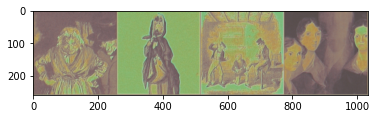

[Epoch 10/50] [Batch 34/34] [D loss: 0.232681] [G loss: 0.925357] ETA: 0:00:16.087967


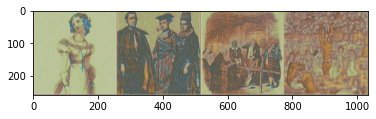

[Epoch 15/50] [Batch 34/34] [D loss: 0.222960] [G loss: 0.742795] ETA: 0:00:14.794427


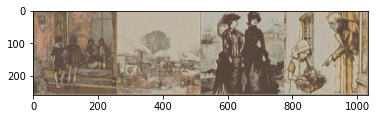

[Epoch 20/50] [Batch 34/34] [D loss: 0.002736] [G loss: 0.968330] ETA: 0:00:15.417760


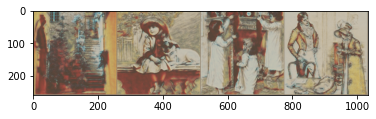

[Epoch 25/50] [Batch 34/34] [D loss: 0.000585] [G loss: 0.999990] ETA: 0:00:15.662105


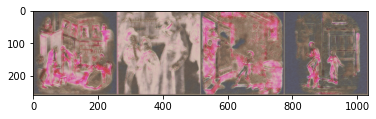

[Epoch 30/50] [Batch 34/34] [D loss: 0.008619] [G loss: 0.997328] ETA: 0:00:15.388837


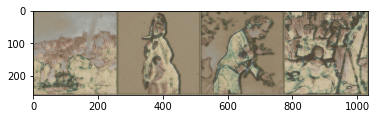

[Epoch 35/50] [Batch 34/34] [D loss: 0.201541] [G loss: 0.998293] ETA: 0:00:15.455658


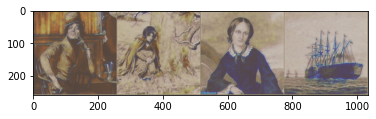

[Epoch 40/50] [Batch 34/34] [D loss: 0.011544] [G loss: 0.999389] ETA: 0:00:15.419755


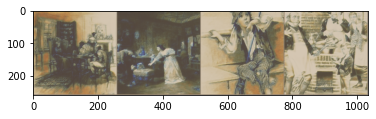

[Epoch 45/50] [Batch 34/34] [D loss: 0.000001] [G loss: 0.999999] ETA: 0:00:15.365898


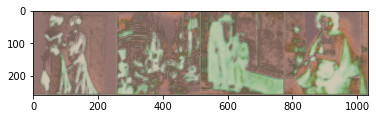

[Epoch 50/50] [Batch 34/34] [D loss: 0.158762] [G loss: 0.997427] ETA: 0:00:15.460645


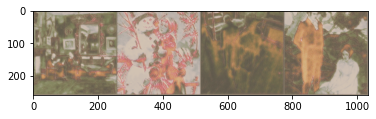

In [ ]:
for epoch in range(max_epoch):
    start_time = datetime.datetime.now()
    loss_D = 0.0
    for i, data in enumerate(train_loader):
        grays, color = data['A'], data['B']
        b_size = len(data['A'])
        

        
        ######## Train Generator ########
        # 生成随机噪声
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)
        # 将灰度图像和噪声拼接作为生成器的输入
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))
        # 使用生成器生成假图像
        fake_img = Gener(gray_noise)
        # 将假图像输入判别器得到输出
        output = Discri(fake_img,b_size)
        # 计算生成器的损失，这里使用均方误差
        g_loss = torch.mean((output-1)**2)
        

        
        ######## Backpropagation & Optimize G ########
        # 清空判别器和生成器的梯度
        Discri.zero_grad()
        Gener.zero_grad()
        # 反向传播计算生成器的梯度
        g_loss.backward()
        # 更新生成器的参数
        optimizerG.step()


       
        ######## Train Discriminator ########
        # 将彩色图像转换为Variable并移动到GPU上
        color = Variable(color.cuda(gpu))
        # 生成随机噪声
        noise = torch.randn(b_size, 1, img_height, img_width).uniform_(0,1)   
        # 将灰度图像和噪声拼接作为生成器的输入
        gray_noise = Variable(torch.cat([grays,noise],dim=1).cuda(gpu))   


        
        ######## Train d to recognize color image as real ########
        # 将彩色图像输入判别器得到输出
        output = Discri(color,b_size)
        # 计算判别器对真实图像的损失，这里使用均方误差
        real_loss = torch.mean((output-1)**2)
        

        
        ######## Train d to recognize fake image as fake ########        
        # 使用生成器生成假图像
        fake_img = Gener(gray_noise)   
        # 将假图像输入判别器得到输出
        output = Discri(fake_img,b_size)
        # 计算判别器对假图像的损失，这里使用均方误差
        fake_loss = torch.mean(output**2)
        

       
        ######## Backpropagation & Optimize D ########
        # 计算判别器的总损失
        d_loss = real_loss + fake_loss
        # 清空判别器和生成器的梯度
        Discri.zero_grad()
        Gener.zero_grad()
        # 反向传播计算判别器的梯度
        d_loss.backward()
        # 更新判别器的参数
        optimizerD.step()        


        fake_img = torchvision.utils.make_grid(fake_img.data) 

    epoch_time = datetime.datetime.now() - start_time
    if (epoch + 1) % 5 == 0:
        torch.save(Gener.state_dict(), "generator_%d.pth" % (epoch+1))
        torch.save(Discri.state_dict(), "discriminator_%d.pth" % (epoch+1))

        print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] ETA: %s" % (epoch+1, max_epoch, i+1, len(train_loader), d_loss.item(), g_loss.item(), epoch_time))
        plt.imshow(reNormalize(fake_img.cpu(), color_mean, color_std))
        plt.show()      


每 5 个 epoch 保存生成模型和判别模型的权重，以便以后可以重新实现学习的模型。然后，输出每个模型的损失值和生成模型生成的图像，以检查它是如何学习的。

通过检查生成模型的损失和判别模型的损失之间的关系来确定适当的 epoch 数非常重要。否则，一种模型将会过度拟合，进一步的学习将变得毫无意义。



## 3.5 预测和性能评估

现在学习已经完成，让我们将其应用到新的黑白图像并将其预测（着色）为彩色图像。加载上面学习的模型的权重，并输入测试数据加载器的图像来进行预测。在本教程中，我们将加载 35 个 epoch 的权重。您可以通过查看图像输出来加载所需纪元的权重，如下所示。

In [ ]:
Gener.load_state_dict(torch.load("generator_35.pth" ))
Discri.load_state_dict(torch.load("discriminator_35.pth" ))

<All keys matched successfully>

==================input==================


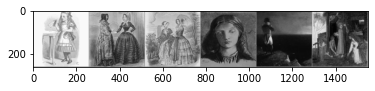

==================target==================


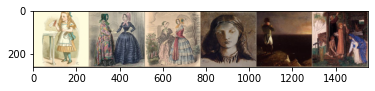

==================output==================


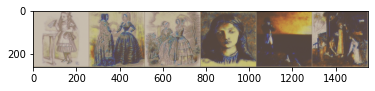

In [ ]:
Discri.eval()
Gener.eval()

fixed_noise = torch.randn(test_batch_size, 1, img_height, img_width).uniform_(0,1)

for i, data in enumerate(test_loader,0) :
    images, label = data['A'], data['B']

    if len(data['A']) != test_batch_size:
        continue

    grays = torch.from_numpy(np.resize(images.numpy(), (test_batch_size, 1, img_height, img_width)))    
    gray = Variable(torch.cat([grays,fixed_noise],dim = 1).cuda(gpu))
    
    output = Gener(gray)

    inputs = torchvision.utils.make_grid(grays)
    labels = torchvision.utils.make_grid(label)
    out = torchvision.utils.make_grid(output.data)

    print('==================input==================')
    plt.imshow(reNormalize(inputs.cpu(), gray_mean, gray_std))
    plt.show()
    print('==================target==================')
    plt.imshow(reNormalize(labels.cpu(), color_mean, color_std))
    plt.show()
    print('==================output==================')
    plt.imshow(reNormalize(out.cpu(), color_mean, color_std))
    plt.show()

结果按以下顺序输出：黑白（输入）、彩色（目标）和生成的图像（输出）。虽然看不清楚，但可以看出相似的颜色在某种程度上被着色了。

到目前为止，在第 3 章中，我们已经构建了一个生成模型 GAN，它将黑白图像转换为彩色图像。在下一章中，我们将使用 pix2pix 模型进行比较，该模型更专门于着色。